## **Phase 1: Anchor Detection**

In [2]:
!pip install opencv-python numpy matplotlib

### **1.1: Anchor Detection**

#### Initial Testing


--- Testing with BLANK001.jpg ---


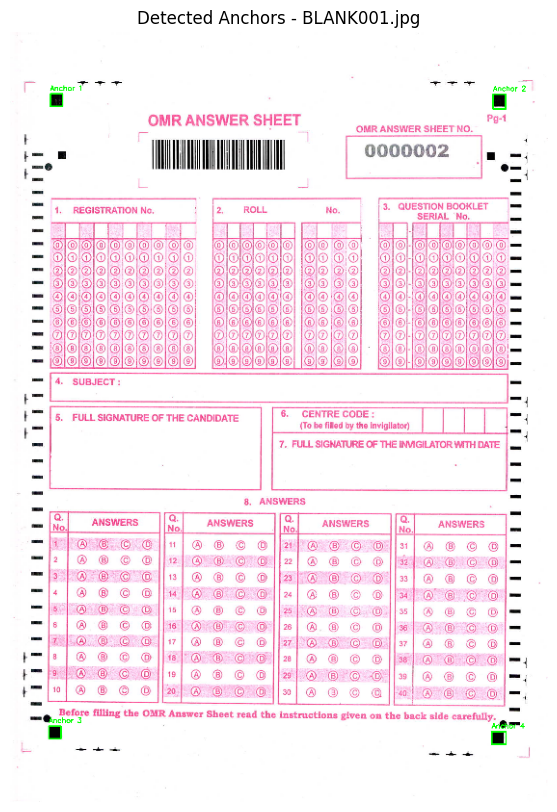


Detected Anchor Details for BLANK001.jpg:
Anchor 1: Bounding Box=(121, 186, 37, 38), Center=(139, 205), Area=1332.0
Anchor 2: Bounding Box=(1456, 187, 38, 45), Center=(1475, 209), Area=1403.0
Anchor 3: Bounding Box=(117, 2093, 36, 38), Center=(135, 2112), Area=1268.5
Anchor 4: Bounding Box=(1452, 2109, 43, 39), Center=(1473, 2128), Area=1388.5


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_anchors_revised(image_path):
    # 1. Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return []

    original_image = image.copy() # Keep a copy for drawing

    # 2. Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 3. Apply adaptive thresholding
    # Increased block size for adaptive thresholding and adjusted C.
    # Larger block size might help capture slightly faded anchors.
    # C is a constant subtracted from the mean or weighted mean.
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 21, 5) # Increased block size (21) and C (5)

    # Optional: Noise reduction (morphological operations)
    # Use a slightly larger kernel for closing to better connect broken parts
    kernel = np.ones((5,5), np.uint8) # Increased kernel size
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1) # Keep open to remove small specks

    # Visualization of thresholded image (for debugging)
    # plt.figure(figsize=(10, 10))
    # plt.imshow(thresh, cmap='gray')
    # plt.title('Thresholded Image (Debugging)')
    # plt.axis('off')
    # plt.show()

    # 4. Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    anchor_candidates = []

    # Get image dimensions to set dynamic area thresholds and position filters
    img_height, img_width = image.shape[:2]
    image_area = img_height * img_width

    # Estimate anchor size:
    # Based on your BLANK001.jpg, the anchors are roughly 2-3% of the image height/width.
    # Let's say a typical anchor side is around 25-35 pixels in a 1000 pixel high image.
    # A rough estimate for anchor area could be (0.02 * min(img_width, img_height))^2 to (0.05 * min(img_width, img_height))^2
    # Or, relative to total image area: 0.0005 to 0.005 of image area.

    # Dynamic area thresholds (adjust these ratios based on your typical image sizes)
    # You might need to refine these by running the script on a few images and seeing the actual areas of anchors.
    min_anchor_area_ratio = 0.0002 # Relaxed a bit
    max_anchor_area_ratio = 0.005  # Ensures we don't pick very large non-anchor shapes
    min_area = image_area * min_anchor_area_ratio
    max_area = image_area * max_anchor_area_ratio


    # 5. Filter contours
    for contour in contours:
        # Get bounding rectangle first to quickly filter out very thin/tall contours
        x, y, w, h = cv2.boundingRect(contour)
        if w == 0 or h == 0: continue

        current_area = cv2.contourArea(contour)
        aspect_ratio = float(w) / h

        # Pre-filter: Check area and very rough aspect ratio first
        if not (min_area < current_area < max_area and
                0.5 < aspect_ratio < 2.0): # Broader aspect ratio for initial filter
            continue

        # Approximate the contour to a polygon
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True) # Adjusted epsilon: 0.02 is often good for squarish shapes

        # Further refine criteria for an anchor
        # Closer to square aspect ratio now
        refined_min_aspect_ratio = 0.8
        refined_max_aspect_ratio = 1.2
        expected_vertices_min = 4 # Should be close to 4
        expected_vertices_max = 6 # Allow for slight imperfections in approximation

        if (len(approx) >= expected_vertices_min and len(approx) <= expected_vertices_max and
            current_area > min_area and current_area < max_area and
            aspect_ratio > refined_min_aspect_ratio and aspect_ratio < refined_max_aspect_ratio):

            # Add center of the bounding box and its area for later sorting/selection
            cx, cy = x + w // 2, y + h // 2
            anchor_candidates.append({"bbox": (x, y, w, h), "center": (cx, cy), "area": current_area, "contour": contour})

    # 6. Select the four most extreme anchors
    # If we found more than 4, we need a robust way to pick the corner ones.
    # If less than 4, we return what we found.

    if len(anchor_candidates) < 4:
        print(f"Warning: Found only {len(anchor_candidates)} potential anchors. May not be enough.")
        # Sort by area for consistency, though this might not guarantee corners
        anchor_candidates.sort(key=lambda a: a["area"], reverse=True)
        return anchor_candidates


    # A more robust selection for 4 anchors: find the ones closest to the corners of the image
    # We can divide the image into quadrants and pick one anchor from each,
    # or find the anchors with min/max x and y coordinates.

    # Initialize with extreme values
    top_left_anchor = None
    top_right_anchor = None
    bottom_left_anchor = None
    bottom_right_anchor = None

    # Use a large distance to ensure first assignment
    max_dist = np.sqrt(img_width**2 + img_height**2) # Diagonal distance

    # Define theoretical corner points
    # You might want to adjust these slightly inwards if anchors are never right at the absolute corner
    corner_coords = {
        "top_left": (0, 0),
        "top_right": (img_width, 0),
        "bottom_left": (0, img_height),
        "bottom_right": (img_width, img_height)
    }

    # Find the anchor closest to each corner
    for candidate in anchor_candidates:
        cx, cy = candidate["center"]

        # Calculate distances to theoretical corners
        dist_tl = np.sqrt((cx - corner_coords["top_left"][0])**2 + (cy - corner_coords["top_left"][1])**2)
        dist_tr = np.sqrt((cx - corner_coords["top_right"][0])**2 + (cy - corner_coords["top_right"][1])**2)
        dist_bl = np.sqrt((cx - corner_coords["bottom_left"][0])**2 + (cy - corner_coords["bottom_left"][1])**2)
        dist_br = np.sqrt((cx - corner_coords["bottom_right"][0])**2 + (cy - corner_coords["bottom_right"][1])**2)

        if top_left_anchor is None or dist_tl < np.sqrt((top_left_anchor["center"][0] - corner_coords["top_left"][0])**2 + (top_left_anchor["center"][1] - corner_coords["top_left"][1])**2):
            top_left_anchor = candidate

        # NOTE: This simple closest-point assignment can lead to one anchor being assigned to multiple corners
        # if other anchors are poorly filtered or positioned.
        # A more robust approach involves a voting system or partitioning the image.

    # Let's try a simpler approach if we have more than 4 candidates:
    # Sort by coordinates and pick the extremes. This worked better in the previous version for 4.
    # Filter for only 4 distinct corners based on quadrant or clear x/y separation.

    # Sort candidates by x and y coordinates to find the extremes
    # This is more reliable if you know there are exactly 4 and they are in the corners.

    # A more robust way to select 4 from a larger pool:
    # Try to find one candidate that has a small X and small Y (top-left)
    # One with large X and small Y (top-right)
    # One with small X and large Y (bottom-left)
    # One with large X and large Y (bottom-right)

    # Sort candidates by their x and y coordinates to determine corners
    anchor_candidates_sorted_x = sorted(anchor_candidates, key=lambda a: a["center"][0])
    anchor_candidates_sorted_y = sorted(anchor_candidates, key=lambda a: a["center"][1])

    # Attempt to pick the corners by approximate position
    # This assumes the anchors are roughly in the corners.
    corners = []
    threshold_x_left = img_width * 0.2 # Arbitrary threshold for "left" side
    threshold_x_right = img_width * 0.8 # Arbitrary threshold for "right" side
    threshold_y_top = img_height * 0.2 # Arbitrary threshold for "top" side
    threshold_y_bottom = img_height * 0.8 # Arbitrary threshold for "bottom" side

    # Find top-left
    for cand in anchor_candidates:
        cx, cy = cand["center"]
        if cx < threshold_x_left and cy < threshold_y_top:
            corners.append(cand)
            break # Found one, move to next corner

    # Find top-right
    for cand in anchor_candidates:
        cx, cy = cand["center"]
        if cx > threshold_x_right and cy < threshold_y_top and cand not in corners:
            corners.append(cand)
            break

    # Find bottom-left
    for cand in anchor_candidates:
        cx, cy = cand["center"]
        if cx < threshold_x_left and cy > threshold_y_bottom and cand not in corners:
            corners.append(cand)
            break

    # Find bottom-right
    for cand in anchor_candidates:
        cx, cy = cand["center"]
        if cx > threshold_x_right and cy > threshold_y_bottom and cand not in corners:
            corners.append(cand)
            break

    # If we still don't have 4, or if the positional filtering was too strict,
    # fall back to sorting by area and taking top 4, but add a warning.
    if len(corners) != 4:
        print(f"Warning: Positional filtering found {len(corners)} anchors. Falling back to top 4 by area.")
        anchor_candidates.sort(key=lambda a: a["area"], reverse=True)
        selected_anchors = anchor_candidates[:4]
    else:
        # Ensure a consistent order if all 4 are found by position
        # (e.g., top-left, top-right, bottom-right, bottom-left)
        # This requires sorting the `corners` list, or finding them directly in this order.
        # For simplicity, let's just return the `corners` list as is, and sort them later outside if needed.
        selected_anchors = corners
        # Further sort them to ensure consistent order (TL, TR, BR, BL) for subsequent use
        selected_anchors.sort(key=lambda p: (p['center'][1], p['center'][0])) # Sort by y then x

    return selected_anchors

# --- How to use it ---
# Test with BLANK001.jpg
image_path_blank = 'BLANK001.jpg'
print(f"\n--- Testing with {image_path_blank} ---")
found_anchors_blank = detect_anchors_revised(image_path_blank)

# Visualize the detected anchors
image_display_blank = cv2.imread(image_path_blank)
if image_display_blank is not None:
    for i, anchor in enumerate(found_anchors_blank):
        x, y, w, h = anchor["bbox"]
        cv2.rectangle(image_display_blank, (x, y), (x + w, y + h), (0, 255, 0), 3) # Green rectangle
        cv2.putText(image_display_blank, f'Anchor {i+1}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    display_height_blank = 800
    display_width_blank = int(image_display_blank.shape[1] * (display_height_blank / image_display_blank.shape[0]))
    resized_image_blank = cv2.resize(image_display_blank, (display_width_blank, display_height_blank))

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(resized_image_blank, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected Anchors - {image_path_blank}')
    plt.axis('off')
    plt.show()

    print("\nDetected Anchor Details for BLANK001.jpg:")
    for i, anchor in enumerate(found_anchors_blank):
        print(f"Anchor {i+1}: Bounding Box={anchor['bbox']}, Center={anchor['center']}, Area={anchor['area']}")
else:
    print(f"Could not load image for display from {image_path_blank}")


# # Test with TEST-01001.jpg
# image_path_filled = 'TEST-01001.jpg'
# print(f"\n--- Testing with {image_path_filled} ---")
# found_anchors_filled = detect_anchors_revised(image_path_filled)

# # Visualize the detected anchors
# image_display_filled = cv2.imread(image_path_filled)
# if image_display_filled is not None:
#     for i, anchor in enumerate(found_anchors_filled):
#         x, y, w, h = anchor["bbox"]
#         cv2.rectangle(image_display_filled, (x, y), (x + w, y + h), (0, 255, 0), 3) # Green rectangle
#         cv2.putText(image_display_filled, f'Anchor {i+1}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

#     display_height_filled = 800
#     display_width_filled = int(image_display_filled.shape[1] * (display_height_filled / image_display_filled.shape[0]))
#     resized_image_filled = cv2.resize(image_display_filled, (display_width_filled, display_height_filled))

#     plt.figure(figsize=(10, 10))
#     plt.imshow(cv2.cvtColor(resized_image_filled, cv2.COLOR_BGR2RGB))
#     plt.title(f'Detected Anchors - {image_path_filled}')
#     plt.axis('off')
#     plt.show()

#     print("\nDetected Anchor Details for TEST-01001.jpg:")
#     for i, anchor in enumerate(found_anchors_filled):
#         print(f"Anchor {i+1}: Bounding Box={anchor['bbox']}, Center={anchor['center']}, Area={anchor['area']}")
# else:
#     print(f"Could not load image for display from {image_path_filled}")

#### Bulk Testing

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os # Import the os module for path operations

def detect_anchors_revised(image_path):
    """
    Detects anchor points (large black squares) in an OMR sheet image.

    Args:
        image_path (str): The path to the image file.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              'bbox' (x, y, w, h), 'center' (cx, cy), 'area', and 'contour'
              for each detected anchor. Returns an empty list if no image or anchors.
    """
    # 1. Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return []

    original_image = image.copy() # Keep a copy for drawing

    # 2. Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 3. Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 21, 5)

    # Optional: Noise reduction (morphological operations)
    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    # 4. Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    anchor_candidates = []

    # Get image dimensions to set dynamic area thresholds and position filters
    img_height, img_width = image.shape[:2]
    image_area = img_height * img_width

    # Dynamic area thresholds (adjust these ratios based on your typical image sizes)
    min_anchor_area_ratio = 0.0002
    max_anchor_area_ratio = 0.005
    min_area = image_area * min_anchor_area_ratio
    max_area = image_area * max_anchor_area_ratio

    # 5. Filter contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w == 0 or h == 0: continue

        current_area = cv2.contourArea(contour)
        aspect_ratio = float(w) / h

        # Pre-filter: Check area and very rough aspect ratio first
        if not (min_area < current_area < max_area and
                0.5 < aspect_ratio < 2.0):
            continue

        # Approximate the contour to a polygon
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        # Further refine criteria for an anchor
        refined_min_aspect_ratio = 0.8
        refined_max_aspect_ratio = 1.2
        expected_vertices_min = 4
        expected_vertices_max = 6

        if (len(approx) >= expected_vertices_min and len(approx) <= expected_vertices_max and
            current_area > min_area and current_area < max_area and
            aspect_ratio > refined_min_aspect_ratio and aspect_ratio < refined_max_aspect_ratio):

            cx, cy = x + w // 2, y + h // 2
            anchor_candidates.append({"bbox": (x, y, w, h), "center": (cx, cy), "area": current_area, "contour": contour})

    # 6. Select the four most extreme anchors using positional filtering
    corners = []
    # Adjust these thresholds based on your anchor placement.
    # They define the regions for top/bottom/left/right.
    threshold_x_left = img_width * 0.2
    threshold_x_right = img_width * 0.8
    threshold_y_top = img_height * 0.2
    threshold_y_bottom = img_height * 0.8

    # To ensure we get distinct corners, track which candidates have been added
    added_candidates_indices = set()

    # Find top-left
    for i, cand in enumerate(anchor_candidates):
        cx, cy = cand["center"]
        if cx < threshold_x_left and cy < threshold_y_top:
            corners.append(cand)
            added_candidates_indices.add(i)
            break

    # Find top-right
    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx > threshold_x_right and cy < threshold_y_top:
                corners.append(cand)
                added_candidates_indices.add(i)
                break

    # Find bottom-left
    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx < threshold_x_left and cy > threshold_y_bottom:
                corners.append(cand)
                added_candidates_indices.add(i)
                break

    # Find bottom-right
    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx > threshold_x_right and cy > threshold_y_bottom:
                corners.append(cand)
                added_candidates_indices.add(i)
                break

    if len(corners) != 4:
        print(f"Warning for {os.path.basename(image_path)}: Positional filtering found {len(corners)} anchors. Falling back to top 4 by area.")
        anchor_candidates.sort(key=lambda a: a["area"], reverse=True)
        selected_anchors = anchor_candidates[:4]
    else:
        selected_anchors = corners
        # Sort them to ensure consistent order (e.g., top-left, top-right, bottom-right, bottom-left)
        # This sort order is usually for deskewing, so ensure it makes sense for your next step.
        # A common order for homography is TL, TR, BR, BL.
        # This sorts primarily by y-coordinate, then by x-coordinate for tie-breaking,
        # which groups top points, then sorts them left-to-right, etc.
        selected_anchors.sort(key=lambda p: (p['center'][1], p['center'][0]))

    return selected_anchors

def process_folder_for_anchors(folder_path, output_results_dir="anchor_detection_results"):
    """
    Processes all image files in a specified folder to detect anchors.
    Saves visualization of detected anchors for each image.

    Args:
        folder_path (str): The path to the folder containing image files.
        output_results_dir (str): Directory to save visualization results.
    """
    if not os.path.isdir(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    os.makedirs(output_results_dir, exist_ok=True) # Create output directory if it doesn't exist

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

    if not image_files:
        print(f"No image files found in '{folder_path}'. Supported formats: .png, .jpg, .jpeg, .bmp, .tif, .tiff")
        return

    print(f"Found {len(image_files)} image(s) in '{folder_path}'. Starting anchor detection...")

    for image_filename in sorted(image_files): # Sort for consistent processing order
        image_path = os.path.join(folder_path, image_filename)
        print(f"\n--- Processing {image_filename} ---")

        found_anchors = detect_anchors_revised(image_path)

        # Visualize and save the result for each image
        image_display = cv2.imread(image_path)
        if image_display is not None:
            for i, anchor in enumerate(found_anchors):
                x, y, w, h = anchor["bbox"]
                cv2.rectangle(image_display, (x, y), (x + w, y + h), (0, 255, 0), 3) # Green rectangle
                cv2.putText(image_display, f'Anchor {i+1}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Save the result image
            output_filepath = os.path.join(output_results_dir, f"detected_anchors_{image_filename}")
            cv2.imwrite(output_filepath, image_display)
            print(f"Saved visualization to: {output_filepath}")

            # Print details of found anchors
            print(f"Detected Anchor Details for {image_filename}:")
            for i, anchor in enumerate(found_anchors):
                print(f"  Anchor {i+1}: Bounding Box={anchor['bbox']}, Center={anchor['center']}, Area={anchor['area']:.2f}")
        else:
            print(f"Could not load image for display from {image_path}")

# --- How to use it ---
# IMPORTANT: Replace 'path/to/your/image/folder' with the actual path to your folder
# Example: If your images are in a folder named 'omr_sheets' in the same directory as your script:
# image_folder = 'omr_sheets'

# For demonstration, let's assume 'BLANK001.jpg' and 'image_2b8a90.jpg' are in a folder named '/content/Data'
# You would need to create this folder and place your images inside it.
image_folder = '/content/Data' # Create this folder and put your images here

process_folder_for_anchors(image_folder)

print("\nProcessing complete. Check the 'anchor_detection_results' folder for output images.")

Found 11 image(s) in '/content/Data'. Starting anchor detection...

--- Processing BLANK001.jpg ---
Saved visualization to: anchor_detection_results/detected_anchors_BLANK001.jpg
Detected Anchor Details for BLANK001.jpg:
  Anchor 1: Bounding Box=(121, 186, 37, 38), Center=(139, 205), Area=1332.00
  Anchor 2: Bounding Box=(1456, 187, 38, 45), Center=(1475, 209), Area=1403.00
  Anchor 3: Bounding Box=(117, 2093, 36, 38), Center=(135, 2112), Area=1268.50
  Anchor 4: Bounding Box=(1452, 2109, 43, 39), Center=(1473, 2128), Area=1388.50

--- Processing TEST-01001.jpg ---
Saved visualization to: anchor_detection_results/detected_anchors_TEST-01001.jpg
Detected Anchor Details for TEST-01001.jpg:
  Anchor 1: Bounding Box=(1481, 200, 38, 45), Center=(1500, 222), Area=1352.50
  Anchor 2: Bounding Box=(147, 213, 36, 37), Center=(165, 231), Area=1260.00
  Anchor 3: Bounding Box=(144, 2112, 37, 38), Center=(162, 2131), Area=1267.50
  Anchor 4: Bounding Box=(1481, 2141, 37, 39), Center=(1499, 2160), 

### **1.2: Skew Detection**

#### Checking for Skew

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

# (Keep detect_anchors_revised and calculate_skew_angle functions exactly as before)
# ... [Paste the entire detect_anchors_revised function here] ...
def detect_anchors_revised(image_path):
    """
    Detects anchor points (large black squares) in an OMR sheet image.
    (This function remains largely the same as the previous successful version)

    Args:
        image_path (str): The path to the image file.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              'bbox' (x, y, w, h), 'center' (cx, cy), 'area', and 'contour'
              for each detected anchor. Returns an empty list if no image or anchors.
              The list of anchors is sorted in a general top-left to bottom-right fashion.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return []

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 21, 5)

    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    anchor_candidates = []

    img_height, img_width = image.shape[:2]
    image_area = img_height * img_width

    min_anchor_area_ratio = 0.0002
    max_anchor_area_ratio = 0.005
    min_area = image_area * min_anchor_area_ratio
    max_area = image_area * max_anchor_area_ratio

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w == 0 or h == 0: continue

        current_area = cv2.contourArea(contour)
        aspect_ratio = float(w) / h

        if not (min_area < current_area < max_area and
                0.5 < aspect_ratio < 2.0):
            continue

        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        refined_min_aspect_ratio = 0.8
        refined_max_aspect_ratio = 1.2
        expected_vertices_min = 4
        expected_vertices_max = 6

        if (len(approx) >= expected_vertices_min and len(approx) <= expected_vertices_max and
            current_area > min_area and current_area < max_area and
            aspect_ratio > refined_min_aspect_ratio and aspect_ratio < refined_max_aspect_ratio):

            cx, cy = x + w // 2, y + h // 2
            anchor_candidates.append({"bbox": (x, y, w, h), "center": (cx, cy), "area": current_area, "contour": contour})

    # Robust positional selection for 4 anchors
    corners = []
    threshold_x_left = img_width * 0.2
    threshold_x_right = img_width * 0.8
    threshold_y_top = img_height * 0.2
    threshold_y_bottom = img_height * 0.8

    added_candidates_indices = set()

    for i, cand in enumerate(anchor_candidates):
        cx, cy = cand["center"]
        if cx < threshold_x_left and cy < threshold_y_top:
            if cand not in corners: # Ensure unique anchors
                corners.append(cand)
                added_candidates_indices.add(i)
                break

    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx > threshold_x_right and cy < threshold_y_top:
                if cand not in corners:
                    corners.append(cand)
                    added_candidates_indices.add(i)
                    break

    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx < threshold_x_left and cy > threshold_y_bottom:
                if cand not in corners:
                    corners.append(cand)
                    added_candidates_indices.add(i)
                    break

    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx > threshold_x_right and cy > threshold_y_bottom:
                if cand not in corners:
                    corners.append(cand)
                    added_candidates_indices.add(i)
                    break

    if len(corners) != 4:
        print(f"Warning: Positional filtering found {len(corners)} anchors. Falling back to top 4 by area.")
        anchor_candidates.sort(key=lambda a: a["area"], reverse=True)
        selected_anchors = anchor_candidates[:4]
    else:
        selected_anchors = corners
        selected_anchors.sort(key=lambda p: (p['center'][1], p['center'][0]))

    return selected_anchors

# ... [Paste the entire calculate_skew_angle function here] ...
def calculate_skew_angle(anchors):
    """
    Calculates the skew angle of the OMR sheet using its four corner anchors.
    Assumes anchors are provided and properly identifiable as corners.

    Args:
        anchors (list): A list of 4 anchor dictionaries, ideally representing
                        the top-left, top-right, bottom-left, bottom-right corners.

    Returns:
        float: The skew angle in degrees, or None if anchors are insufficient.
    """
    if len(anchors) != 4:
        print("Error: Need exactly 4 anchors to calculate skew angle.")
        return None

    # Sort all anchors by y-coordinate to separate top two from bottom two
    anchors_copy = sorted(anchors, key=lambda p: p['center'][1]) # Create a copy to not modify original list in place
    top_two = sorted(anchors_copy[:2], key=lambda p: p['center'][0])  # Sort top two by x-coordinate
    bottom_two = sorted(anchors_copy[2:], key=lambda p: p['center'][0]) # Sort bottom two by x-coordinate

    tl = top_two[0]
    tr = top_two[1]
    bl = bottom_two[0]
    br = bottom_two[1]

    # Calculate angle for the top edge
    p1_top = tl["center"]
    p2_top = tr["center"]

    delta_y_top = p2_top[1] - p1_top[1]
    delta_x_top = p2_top[0] - p1_top[0]
    angle_top_rad = math.atan2(delta_y_top, delta_x_top)
    angle_top_deg = math.degrees(angle_top_rad)

    # Calculate angle for the bottom edge
    p1_bottom = bl["center"]
    p2_bottom = br["center"]

    delta_y_bottom = p2_bottom[1] - p1_bottom[1]
    delta_x_bottom = p2_bottom[0] - p1_bottom[0]
    angle_bottom_rad = math.atan2(delta_y_bottom, delta_x_bottom)
    angle_bottom_deg = math.degrees(angle_bottom_rad)

    skew_angle = (angle_top_deg + angle_bottom_deg) / 2.0

    return skew_angle


def process_folder_for_anchors_and_skew(folder_path, output_results_dir="anchor_detection_results_with_skew"):
    """
    Processes all image files in a specified folder to detect anchors and calculate skew.
    Saves visualization of detected anchors for each image.

    Args:
        folder_path (str): The path to the folder containing image files.
        output_results_dir (str): Directory to save visualization results.
    """
    if not os.path.isdir(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    os.makedirs(output_results_dir, exist_ok=True)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

    if not image_files:
        print(f"No image files found in '{folder_path}'. Supported formats: .png, .jpg, .jpeg, .bmp, .tif, .tiff")
        return

    print(f"Found {len(image_files)} image(s) in '{folder_path}'. Starting anchor and skew detection...")

    for image_filename in sorted(image_files):
        image_path = os.path.join(folder_path, image_filename)
        print(f"\n--- Processing {image_filename} ---")

        found_anchors = detect_anchors_revised(image_path)

        skew_angle = None # Initialize skew_angle
        if len(found_anchors) == 4:
            skew_angle = calculate_skew_angle(found_anchors)
            # Print skew angle in the console here
            print(f"Skew angle: {skew_angle:.2f} degrees")
        else:
            print(f"Could not calculate skew: Expected 4 anchors, found {len(found_anchors)}.")

        # Visualize and save the result for each image
        image_display = cv2.imread(image_path)
        if image_display is not None:
            for i, anchor in enumerate(found_anchors):
                x, y, w, h = anchor["bbox"]
                cv2.rectangle(image_display, (x, y), (x + w, y + h), (0, 255, 0), 3)
                cv2.putText(image_display, f'Anchor {i+1}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Add skew angle text to the image (if calculated)
            if skew_angle is not None:
                text = f"Skew: {skew_angle:.2f} deg"
                cv2.putText(image_display, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

            output_filepath = os.path.join(output_results_dir, f"detected_anchors_skew_{image_filename}")
            cv2.imwrite(output_filepath, image_display)
            print(f"Saved visualization with skew to: {output_filepath}")

            # Print anchor details in the console
            print("Detected Anchor Details:")
            for i, anchor in enumerate(found_anchors):
                print(f"  Anchor {i+1}: Bounding Box={anchor['bbox']}, Center={anchor['center']}, Area={anchor['area']:.2f}")
        else:
            print(f"Could not load image for display from {image_path}")

# --- How to use it ---
# IMPORTANT: Replace 'path/to/your/image/folder' with the actual path to your folder
image_folder = '/content/Data' # Ensure this folder exists and contains your OMR images

process_folder_for_anchors_and_skew(image_folder)

print("\nProcessing complete. Check the 'anchor_detection_results_with_skew' folder for output images with skew noted.")

Found 11 image(s) in '/content/Data'. Starting anchor and skew detection...

--- Processing BLANK001.jpg ---
Skew angle: 0.43 degrees
Saved visualization with skew to: anchor_detection_results_with_skew/detected_anchors_skew_BLANK001.jpg
Detected Anchor Details:
  Anchor 1: Bounding Box=(121, 186, 37, 38), Center=(139, 205), Area=1332.00
  Anchor 2: Bounding Box=(1456, 187, 38, 45), Center=(1475, 209), Area=1403.00
  Anchor 3: Bounding Box=(117, 2093, 36, 38), Center=(135, 2112), Area=1268.50
  Anchor 4: Bounding Box=(1452, 2109, 43, 39), Center=(1473, 2128), Area=1388.50

--- Processing TEST-01001.jpg ---
Skew angle: 0.43 degrees
Saved visualization with skew to: anchor_detection_results_with_skew/detected_anchors_skew_TEST-01001.jpg
Detected Anchor Details:
  Anchor 1: Bounding Box=(1481, 200, 38, 45), Center=(1500, 222), Area=1352.50
  Anchor 2: Bounding Box=(147, 213, 36, 37), Center=(165, 231), Area=1260.00
  Anchor 3: Bounding Box=(144, 2112, 37, 38), Center=(162, 2131), Area=126

#### Skewness Handling <br>
*For Images where the skew is over 3 degrees, those images will be placed inside* "**Warning**". *Also, the Skewness Error will be superimposed on the image.*

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

# (Keep detect_anchors_revised and calculate_skew_angle functions exactly as before)
# ... [Paste the entire detect_anchors_revised function here] ...
def detect_anchors_revised(image_path):
    """
    Detects anchor points (large black squares) in an OMR sheet image.
    (This function remains largely the same as the previous successful version)

    Args:
        image_path (str): The path to the image file.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              'bbox' (x, y, w, h), 'center' (cx, cy), 'area', and 'contour'
              for each detected anchor. Returns an empty list if no image or anchors.
              The list of anchors is sorted in a general top-left to bottom-right fashion.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return []

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 21, 5)

    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    anchor_candidates = []

    img_height, img_width = image.shape[:2]
    image_area = img_height * img_width

    min_anchor_area_ratio = 0.0002
    max_anchor_area_ratio = 0.005
    min_area = image_area * min_anchor_area_ratio
    max_area = image_area * max_anchor_area_ratio

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w == 0 or h == 0: continue

        current_area = cv2.contourArea(contour)
        aspect_ratio = float(w) / h

        if not (min_area < current_area < max_area and
                0.5 < aspect_ratio < 2.0):
            continue

        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        refined_min_aspect_ratio = 0.8
        refined_max_aspect_ratio = 1.2
        expected_vertices_min = 4
        expected_vertices_max = 6

        if (len(approx) >= expected_vertices_min and len(approx) <= expected_vertices_max and
            current_area > min_area and current_area < max_area and
            aspect_ratio > refined_min_aspect_ratio and aspect_ratio < refined_max_aspect_ratio):

            cx, cy = x + w // 2, y + h // 2
            anchor_candidates.append({"bbox": (x, y, w, h), "center": (cx, cy), "area": current_area, "contour": contour})

    # Robust positional selection for 4 anchors
    corners = []
    threshold_x_left = img_width * 0.2
    threshold_x_right = img_width * 0.8
    threshold_y_top = img_height * 0.2
    threshold_y_bottom = img_height * 0.8

    added_candidates_indices = set()

    for i, cand in enumerate(anchor_candidates):
        cx, cy = cand["center"]
        if cx < threshold_x_left and cy < threshold_y_top:
            if cand not in corners: # Ensure unique anchors
                corners.append(cand)
                added_candidates_indices.add(i)
                break

    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx > threshold_x_right and cy < threshold_y_top:
                if cand not in corners:
                    corners.append(cand)
                    added_candidates_indices.add(i)
                    break

    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx < threshold_x_left and cy > threshold_y_bottom:
                if cand not in corners:
                    corners.append(cand)
                    added_candidates_indices.add(i)
                    break

    for i, cand in enumerate(anchor_candidates):
        if i not in added_candidates_indices:
            cx, cy = cand["center"]
            if cx > threshold_x_right and cy > threshold_y_bottom:
                if cand not in corners:
                    corners.append(cand)
                    added_candidates_indices.add(i)
                    break

    if len(corners) != 4:
        # Removed print here, now handled in process_folder function
        anchor_candidates.sort(key=lambda a: a["area"], reverse=True)
        selected_anchors = anchor_candidates[:4]
    else:
        selected_anchors = corners
        selected_anchors.sort(key=lambda p: (p['center'][1], p['center'][0]))

    return selected_anchors

# ... [Paste the entire calculate_skew_angle function here] ...
def calculate_skew_angle(anchors):
    """
    Calculates the skew angle of the OMR sheet using its four corner anchors.
    Assumes anchors are provided and properly identifiable as corners.

    Args:
        anchors (list): A list of 4 anchor dictionaries, ideally representing
                        the top-left, top-right, bottom-left, bottom-right corners.

    Returns:
        float: The skew angle in degrees, or None if anchors are insufficient.
    """
    if len(anchors) != 4:
        # print("Error: Need exactly 4 anchors to calculate skew angle.") # Removed redundant print
        return None

    anchors_copy = sorted(anchors, key=lambda p: p['center'][1])
    top_two = sorted(anchors_copy[:2], key=lambda p: p['center'][0])
    bottom_two = sorted(anchors_copy[2:], key=lambda p: p['center'][0])

    tl = top_two[0]
    tr = top_two[1]
    bl = bottom_two[0]
    br = bottom_two[1]

    p1_top = tl["center"]
    p2_top = tr["center"]

    delta_y_top = p2_top[1] - p1_top[1]
    delta_x_top = p2_top[0] - p1_top[0]
    angle_top_rad = math.atan2(delta_y_top, delta_x_top)
    angle_top_deg = math.degrees(angle_top_rad)

    p1_bottom = bl["center"]
    p2_bottom = br["center"]

    delta_y_bottom = p2_bottom[1] - p1_bottom[1]
    delta_x_bottom = p2_bottom[0] - p1_bottom[0]
    angle_bottom_rad = math.atan2(delta_y_bottom, delta_x_bottom)
    angle_bottom_deg = math.degrees(angle_bottom_rad)

    skew_angle = (angle_top_deg + angle_bottom_deg) / 2.0

    return skew_angle


def process_folder_for_anchors_and_skew(folder_path,
                                         output_results_dir="anchor_detection_results_with_skew",
                                         warnings_dir_name="warnings",
                                         max_skew_degrees=3.0): # New parameter for max skew
    """
    Processes all image files in a specified folder to detect anchors and calculate skew.
    Saves visualization of detected anchors for each image.
    If skew exceeds a threshold, saves the image to a 'warnings' subfolder.

    Args:
        folder_path (str): The path to the folder containing image files.
        output_results_dir (str): Directory to save general visualization results.
        warnings_dir_name (str): Name of the subfolder for skewed images.
        max_skew_degrees (float): Maximum allowed absolute skew angle in degrees.
    """
    if not os.path.isdir(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    # Create main output directory
    os.makedirs(output_results_dir, exist_ok=True)
    # Create warnings sub-directory
    warnings_path = os.path.join(output_results_dir, warnings_dir_name)
    os.makedirs(warnings_path, exist_ok=True)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

    if not image_files:
        print(f"No image files found in '{folder_path}'. Supported formats: .png, .jpg, .jpeg, .bmp, .tif, .tiff")
        return

    print(f"Found {len(image_files)} image(s) in '{folder_path}'. Starting anchor and skew detection...")

    for image_filename in sorted(image_files):
        image_path = os.path.join(folder_path, image_filename)
        print(f"\n--- Processing {image_filename} ---")

        found_anchors = detect_anchors_revised(image_path)
        image_skewed_warning = False # Flag to determine if it's a warning image
        reason_text = ""

        skew_angle = None
        if len(found_anchors) == 4:
            skew_angle = calculate_skew_angle(found_anchors)
            print(f"Skew angle: {skew_angle:.2f} degrees")

            if skew_angle is not None and abs(skew_angle) > max_skew_degrees:
                image_skewed_warning = True
                reason_text = "ERROR: MAX SKEW EXCEEDED"
                print(f"  WARNING: Image is skewed more than {max_skew_degrees} degrees!")
        else:
            reason_text = f"ERROR: Not enough anchors ({len(found_anchors)} found)"
            image_skewed_warning = True # Also consider this a warning
            print(f"  WARNING: Could not calculate skew: Expected 4 anchors, found {len(found_anchors)}.")


        # Visualize and save the result for each image
        image_display = cv2.imread(image_path)
        if image_display is not None:
            # Draw anchors
            for i, anchor in enumerate(found_anchors):
                x, y, w, h = anchor["bbox"]
                cv2.rectangle(image_display, (x, y), (x + w, y + h), (0, 255, 0), 3) # Green rectangle
                cv2.putText(image_display, f'Anchor {i+1}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Add skew angle text to the image
            if skew_angle is not None:
                text = f"Skew: {skew_angle:.2f} deg"
                # Use different color for skew text if it's a warning
                text_color = (0, 0, 255) if image_skewed_warning else (255, 0, 0) # Red for warning, Blue for normal
                cv2.putText(image_display, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, text_color, 2)

            # Add reason text if it's a warning image
            if image_skewed_warning:
                # Place warning text lower on the image to avoid overlapping skew text
                cv2.putText(image_display, reason_text, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3) # Red, thicker text

            # Determine where to save the image
            if image_skewed_warning:
                output_filepath = os.path.join(warnings_path, f"SKEWED_{image_filename}")
                print(f"  Saved WARNING image to: {output_filepath}")
            else:
                output_filepath = os.path.join(output_results_dir, f"detected_anchors_skew_{image_filename}")
                print(f"  Saved normal image to: {output_filepath}")

            cv2.imwrite(output_filepath, image_display)

            # Print anchor details in the console
            print("  Detected Anchor Details:")
            for i, anchor in enumerate(found_anchors):
                print(f"    Anchor {i+1}: Bounding Box={anchor['bbox']}, Center={anchor['center']}, Area={anchor['area']:.2f}")
        else:
            print(f"  Could not load image for display from {image_path}")

# --- How to use it ---
image_folder = '/content/Data' # Ensure this folder exists and contains your OMR images
# You can customize the max_skew_degrees when calling the function
process_folder_for_anchors_and_skew(image_folder, max_skew_degrees=3.0)

print("\nProcessing complete. Check the 'anchor_detection_results_with_skew' folder and its 'warnings' subfolder for output images.")

Found 13 image(s) in '/content/Data'. Starting anchor and skew detection...

--- Processing BLANK001.jpg ---
Skew angle: 0.43 degrees
  Saved normal image to: anchor_detection_results_with_skew/detected_anchors_skew_BLANK001.jpg
  Detected Anchor Details:
    Anchor 1: Bounding Box=(121, 186, 37, 38), Center=(139, 205), Area=1332.00
    Anchor 2: Bounding Box=(1456, 187, 38, 45), Center=(1475, 209), Area=1403.00
    Anchor 3: Bounding Box=(117, 2093, 36, 38), Center=(135, 2112), Area=1268.50
    Anchor 4: Bounding Box=(1452, 2109, 43, 39), Center=(1473, 2128), Area=1388.50

--- Processing SKEW-001.jpg ---
Skew angle: -3.75 degrees
  Saved WARNING image to: anchor_detection_results_with_skew/warnings/SKEWED_SKEW-001.jpg
  Detected Anchor Details:
    Anchor 1: Bounding Box=(1788, 241, 49, 51), Center=(1812, 266), Area=2080.00
    Anchor 2: Bounding Box=(143, 360, 48, 49), Center=(167, 384), Area=1964.50
    Anchor 3: Bounding Box=(1955, 2615, 49, 49), Center=(1979, 2639), Area=2085.00
 